## FDR & Conformal Prediction
Based on Selection by Prediction with Conformal p-values by Y. Jin and E. Candés

### False Discovery Rate

The False Discovery Rate is a measure of the expected ratio of "false leads" out rejected null hypotheses. First developed and published by Benjamini and Hochberg in 1995, controlling it is useful for a variety of situations. For example, say we manage a vehicle fleet, and by looking at the history of each car in the fleet we can assign a p-value for the null hypothesis that the car does not need maintenance. By controlling the FDR, we can choose cars such that the proportion of cars sent to maintenance but did not need it is no greater than 10%, thereby reducing costs.

We define the False Discovery Rate in this way:
$$
\text{FDR} = \mathbb E\left[\frac{\text{false positives}}{max(1,\text{total positives})}\right]
$$
Or more precisely, if $\mathcal R$ is the rejection set, and $\mathcal H_0$ is the set of true null hypotheses, then:
$$
\text{FDR} = \mathbb E\left[\frac{|\mathcal R\cap\mathcal H_0|}{max(1,|\mathcal R|)}\right]
$$

Control of the FDR is usually achieved by using the Benjamini-Hochberg (BH) algorithm. Simply put, if the desired maximum FDR is defined as $\alpha$, and we are testing $n$ hypotheses, let $P_{(k)}$ be the $k$-th largest p-value. The algorithm has two steps:
<br>
1. Find the largest $k$ such that $P_{(k)}\leq\frac{k}{n}\alpha$
2. Reject the null hypotheses which have p-values lesser or equal to $P_{(k)}$ (i.e. those corresponding to indices $1,...,k$)

Let's look at a simulation of the BH algorithm. Our setup is:
$$
\alpha=0.1 \\
s\in\{0.5,1,2\} \\
\mu_i\in\{0,1\} \\
X_i|\mu_i\sim \text N(s\cdot\mu_i,1) \\
H_{i,0}:\mu_i=0 \\
H_{i,1}:\mu_i=1 \\
\mathbb P_{H_{i,0}}\left(X_i>x_i\right)=\Phi(-x_i)
$$ 

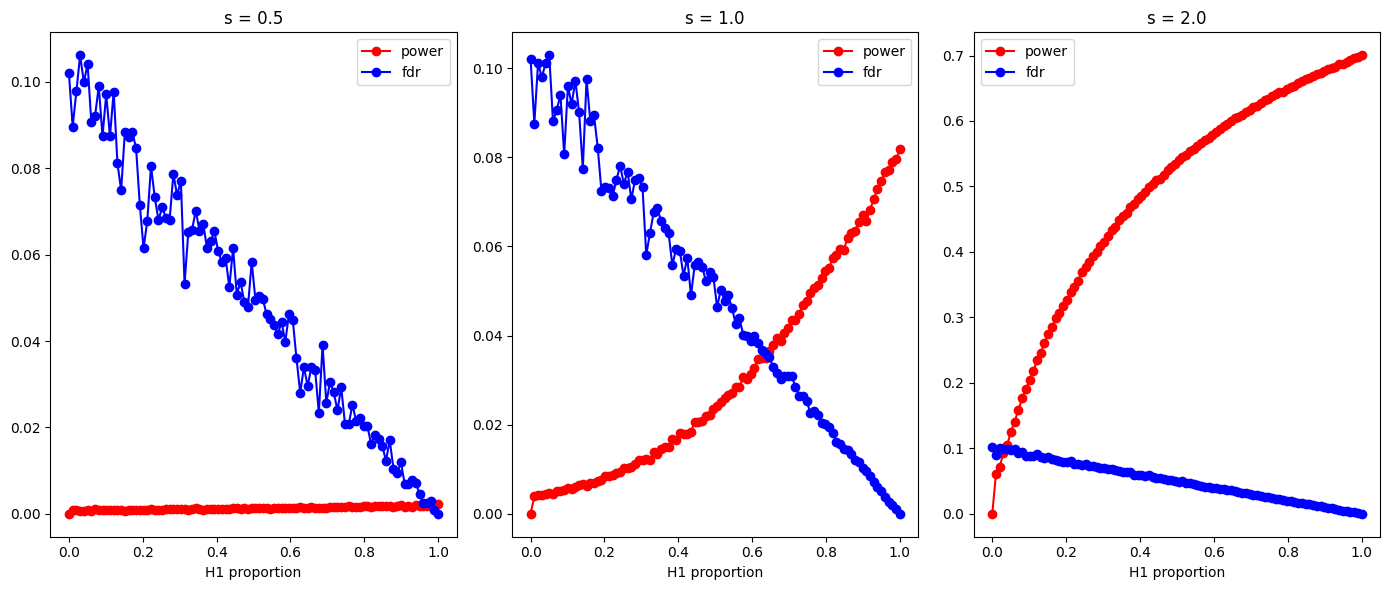

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from utils import benjamini_hochberg

def simulate_simple(n=1000, h1_prop=0.5, scale=1.0):
    h = np.random.binomial(1, h1_prop, size=n) * scale
    x = np.random.normal(h, 1, size=n)
    p_values = 1 - scipy.stats.norm.cdf(x)
    rejected = benjamini_hochberg(p_values, q=0.1)
    return h > 0, rejected

def show_stats_for_simple(axis, scale=1.0):
    h1_props = np.linspace(0, 1, 100)
    np.random.seed(42)
    result = {'power': [], 'fdr': []}
    for h1_prop in h1_props:
        power = []
        fdr = []
        for _ in range(1000):
            alt_true, rejected = simulate_simple(h1_prop=h1_prop, scale=scale)
            power.append((rejected & alt_true).sum() / max(1, alt_true.sum()))
            fdr.append((rejected & ~alt_true).sum() / max(1, rejected.sum()))
        
        result['power'].append(np.mean(power))
        result['fdr'].append(np.mean(fdr))
    
    axis.plot(h1_props, result['power'], label='power', color='red', marker='o')
    axis.plot(h1_props, result['fdr'], label='fdr', color='blue', marker='o')
    axis.set_xlabel('H1 proportion')
    axis.title.set_text(f's = {scale}')
    axis.legend(loc='best')

_, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 6))
show_stats_for_simple(axis=axes[0], scale=0.5)
show_stats_for_simple(axis=axes[1], scale=1.0)
show_stats_for_simple(axis=axes[2], scale=2.0)
plt.tight_layout()
plt.show()

We can see that although the power of the algorithm increases when detection is made easier, the FDR itself only changes according to the proportion of $H_1$ in the data. Also, we can see that the control BH applies of FDR does not guarantee equality, but rather a ceiling: When the proportion of $H_1$ is low, the p-values reflect the general behaviour of the data. But when the proportion of $H_1$ is high, there might not be enough samples from $H_0$ with low-enough p-value to reject, in order to increase the FDR to 10%.

### Random Hypotheses

In conventional statistics, a hypothesis is an assumption about the state of the world. It is either true or it is false. In the example I gave above, whether a car requires maintenance is either true or not. In the paper discussed here, however, the authors investigated <b>random hypotheses</b>. Expanding the example, what if we wanted to ask, instead of which cars need maintenance, instead which car will break down in the next 12 months. This is about <b>predicting an event</b>, which adds a measure of uncertainty. To illustrate, consider the scenario: Let $\mu_i$ be 0 if car $i$ does not require maintenance and 1 otherwise, $X_i|\mu_i\sim\text N(\mu_i,1)$. Then a p-value for the conventional hypothesis is:
$$
\mathbb P(X_i>x_i|\mu_i=0)
$$
Let $Y_i$ be the time until car $i$ breaks down, minus 12 months (so $Y_i\leq 0$ if car $i$ will break down in the next 12 months). Then the random hypothesis p-value is:
$$
\mathbb P(X_i>x_i|Y_i\leq 0)
$$
This tends to be less powerful than conventional p-values, for example here since $Y_i\leq 0$ holds less information about the distribution of $X_i$ than $\mu_i=0$.

Let's look at a simulation of BH over random hypotheses. Our setup is:
$$
\alpha=0.1 \\
\mu_0\in[-5,5] \\
\sigma_0\in\{0.5,1,2\} \\
X_i\sim\text N(\mu_0,\sigma_0^2) \\
Y_i|X_i\sim\text N(X_i,1) \\
X_i|Y_i\sim\text N\left(\frac{1}{\sigma_0^{-2}+1}\left(\frac{\mu_0}{\sigma_0^2}+Y_i\right),\frac{1}{\sigma_0^{-2}+1}\right) \\
H_{i,0}:Y_i\leq 0 \\
\mathbb P(X_i>x_i|H_{i,0})\leq\mathbb P(X_i>x_i|Y_i=0)=1-\Phi\left(\frac{x_i-\frac{1}{\sigma_0^{-2}+1}\left(\frac{\mu_0}{\sigma_0^2}+0\right)}{\frac{1}{\sigma_0^{-2}+1}}\right)
$$
In this case, the FDR is defined as:
$$
\text{FDR}=\mathbb E\left[\frac{\sum_{i=1}^n\mathbb 1\{i\in\mathcal R\}\cdot\mathbb 1\{Y_i\leq 0\}}{max(1,|\mathcal R|)}\right]
$$

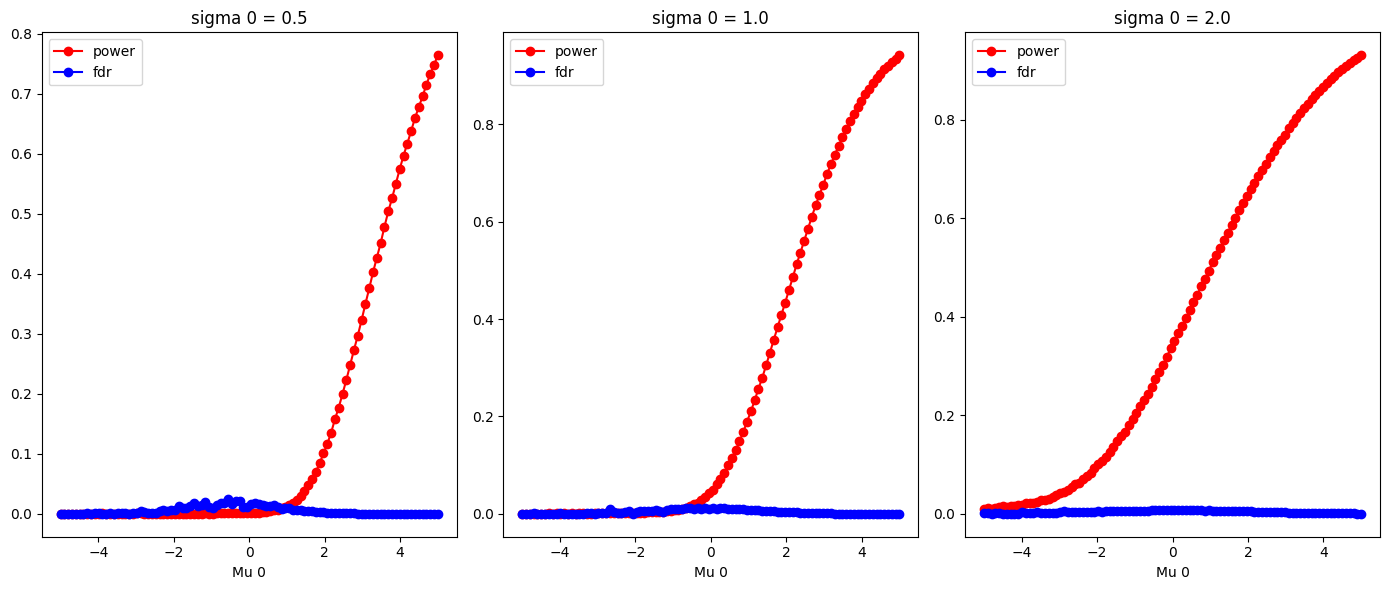

In [5]:
def simulate_random_hyp(n=1000, mu=0.0, scale=1.0):
    x = np.random.normal(mu, scale, size=n)
    y = np.random.normal(x, 1, size=n)
    sigma_n_sq = 1/(1+scale**(-2))
    p_values = 1 - scipy.stats.norm.cdf(x, loc=sigma_n_sq*mu/(scale**2), scale=sigma_n_sq**0.5)
    rejected = benjamini_hochberg(p_values, q=0.1)
    return y > 0, rejected

def show_stats_for_random_hyp(axis, scale=1.0):
    np.random.seed(42)
    result = {'power': [], 'fdr': []}
    locs = np.linspace(-5.0, 5.0, 100)
    for loc in locs:
        power = []
        fdr = []
        for _ in range(1000):
            alt_true, rejected = simulate_random_hyp(mu=loc, scale=scale)
            power.append((rejected & alt_true).sum() / max(1, alt_true.sum()))
            fdr.append((rejected & ~alt_true).sum() / max(1, rejected.sum()))
        
        result['power'].append(np.mean(power))
        result['fdr'].append(np.mean(fdr))
    
    axis.plot(locs, result['power'], label='power', color='red', marker='o')
    axis.plot(locs, result['fdr'], label='fdr', color='blue', marker='o')
    axis.set_xlabel('Mu 0')
    axis.title.set_text(f'sigma 0 = {scale}')
    axis.legend(loc='best')

_, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 6))
show_stats_for_random_hyp(axis=axes[0], scale=0.5)
show_stats_for_random_hyp(axis=axes[1], scale=1.0)
show_stats_for_random_hyp(axis=axes[2], scale=2.0)
plt.tight_layout()
plt.show()

Here, it is much harder to differentiate between cases, leading to rapid increase in power, as well as a low FDR overall.

### Conformal Random Hypotheses

Conformal prediction is a process that uses a point-prediction model, together with a set of calibration data, into a confidence-interval model. It is especially useful when we wish to make predictions without assuming that the data we look at belong to a specific distribution. In a conformal prediction scenario, we have the following:
<br>
Calibration data $(X_i,Y_i)\in\mathcal X\times\mathcal Y$, $i=1,...,n$
<br>
A trained point prediction model $f:\mathcal X\rightarrow\mathcal Y$ henceforth referred to as $\hat Y$
<br>
A nonconformity score $V:\mathcal X\times\mathcal Y\rightarrow\mathbb R$ based on the prediction. $V(x,y)$ should, intuitively, measures how well $y$ <i>conforms</i> to the prediction $\hat y$. Various distance functions are applicable.
<br>
If we can observe $(X_{n+j},Y_{n+j})$, we could calculate the <i>conformal p-value</i>:
$$
V_i=V(X_i,Y_i) \\
V_{n+j}=V(X_{n+j},Y_{n+j}) \\
p^*_j=\frac{\sum_{i=1}^n\mathbb 1\{V_i<V_{n+j}\}+U_j\cdot\left(1+\sum_{i=1}^n\mathbb 1\{V_i=V_{n+j}\}\right)}{n+1}
$$
where $U_j\sim\text{Unif}[0,1]$ to break ties. Under the null hypothesis that $(X_1,Y_1),...,(X_n,Y_n),(X_{n+j},Y_{n+j})$ are all drawn from the same distribution, then $p^*_j\sim\text{Unif}[0,1]$.

In the paper, the scenario investigated is one where $Y_{n+j}$ is not observed. Instead, we have $X_{n+1},...,X_{n+m}$, and we can calculate the conformal p-values of the null hypotheses $H_{0,n+j}:Y_{n+j}\leq c_j$ by using $V_{n+j}=V(X_{n+j},c_j)$, and requiring $V$ to be monotone over the second index, that is $\forall x\in\mathcal X$ $y\leq y'\Rightarrow V(x,y)\leq V(x,y')$.

However, these p-values are not similar to conventional p-values, for a few reasons. First, they are not dependent on selection. Remember, a conventional p-value obeys the following:
$$
p_i=\mathbb P(X_i>x_i|H_{0,i})
$$
that is, it is specific on $x_i$. But conformal prediction p-value are actually this:
$$
p_i=\mathbb P(X_i>x_i\wedge H_{0,i})
$$
so their guarantee is global, over all $\mathcal X$. Additionally, conformal p-values are not independent, but rather exchangeable.

The authors of the paper prove that the BH algorithm, originally developed for conventional statistics, is still valid, that is, there is guaranteed control of FDR given that a few requirements are satisfied, relating to the nonconformity function and exchangeability of the data. This is a novel result, and allows us to use this new "cfBH" algorithm with strong guarantees.

Let's look at a simulation of cfBH. Our setup is this:
$$
\alpha=0.1 \\
\mu_0\in[-5,5] \\
\sigma_0\in\{0.5,1,2\} \\
i=1,...,2000 \\
X_i\sim\text N(\mu_0,\sigma_0^2) \\
Y_i|X_i\sim\text N(X_i,1) \\
n=1000 \\
V(x,y):=1000\cdot(y>0)-x \\
H_{0,n+j}:Y_{n+j}\leq 0
$$
where $n=1000$ signifies that 1000 data points are used as calibration data, and the other 1000 data points are used as test for FDR calculation. Choice of nonconformity function following suggestion by the authors, of the shape $V(x_{n+j},y_{n+j})=M\cdot(y_{n+j}>c_j)-\hat y_{n+j})$.

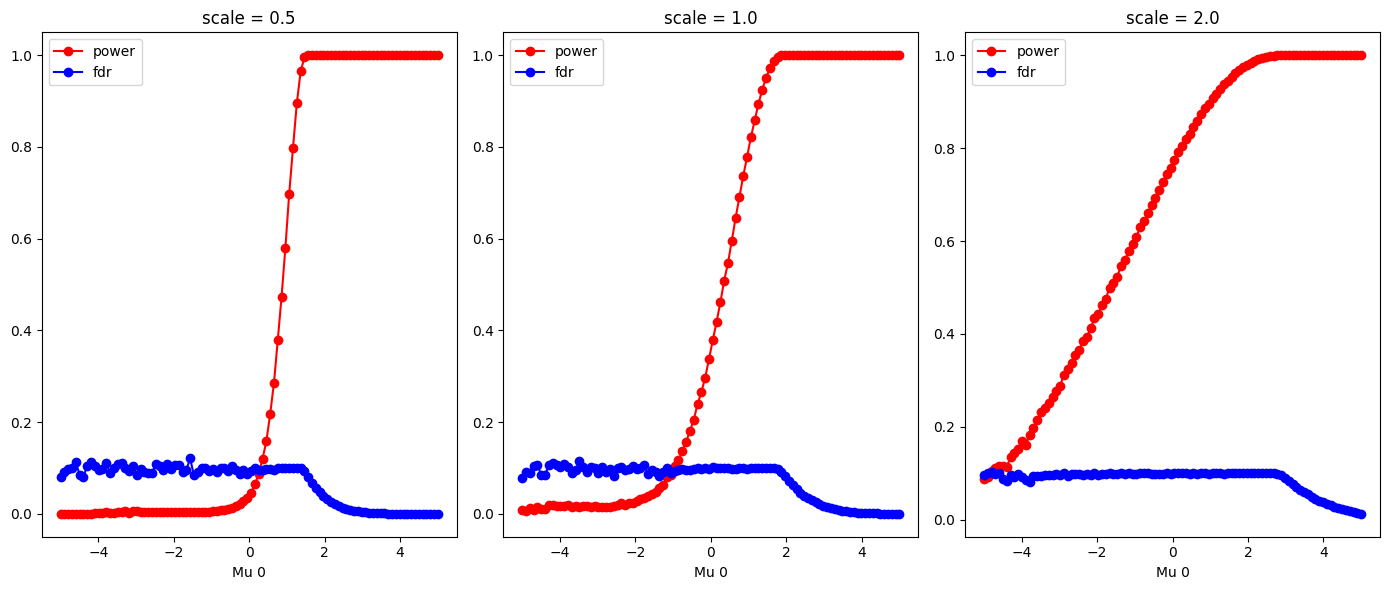

In [8]:
from conformal_bh.utils import conformal_p_values

def simulate_conformal_random_hyp(n=1000, mu=0.0, scale=1.0):
    x = np.random.normal(mu, scale, size=n*2)
    y = np.random.normal(x, 1, size=n*2)
    p_values = conformal_p_values(1000 * (y[:n] > 0) - x[:n], -x[n:])
    rejected = benjamini_hochberg(p_values, q=0.1)
    return y[n:] > 0, rejected

def show_stats_for_conformal_random_hyp(axis, scale=1.0):
    np.random.seed(42)
    result = {'power': [], 'fdr': []}
    locs = np.linspace(-5.0, 5.0, 100)
    for loc in locs:
        power = []
        fdr = []
        for _ in range(1000):
            alt_true, rejected = simulate_conformal_random_hyp(mu=loc, scale=scale)
            power.append((rejected & alt_true).sum() / max(1, alt_true.sum()))
            fdr.append((rejected & ~alt_true).sum() / max(1, rejected.sum()))
        
        result['power'].append(np.mean(power))
        result['fdr'].append(np.mean(fdr))
    
    axis.plot(locs, result['power'], label='power', color='red', marker='o')
    axis.plot(locs, result['fdr'], label='fdr', color='blue', marker='o')
    axis.set_xlabel('Mu 0')
    axis.title.set_text(f'scale = {scale}')
    axis.legend(loc='best')

_, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 6))
show_stats_for_conformal_random_hyp(axis=axes[0], scale=0.5)
show_stats_for_conformal_random_hyp(axis=axes[1], scale=1.0)
show_stats_for_conformal_random_hyp(axis=axes[2], scale=2.0)
plt.tight_layout()
plt.show()

We can see here that FDR is kept at 10% throughout, until a point where there's probably not enough data points that satisfy $y_{n+j}\leq 0$ to keep the FDR up. 

### Conclusion

There's a lot of potential applications for this type of analysis. In fact, although the authors of the paper used machine learning algorithms to create simulations, there's no actual need for point prediction to use cfBH - the only thing needed is a monotone scoring function. If we return to our vehicle fleet example, the algorithm works perfectly fine if a simple metric like mileage $X_i$ and time until malfunction $Y_i$. If we took a simple nonconformity function like $V(x,y):=y-x$, the guarantees should still hold.